# Human RNA editing landscape of REDIportal (GPU-based)

### Part V Extract clusters from large dataset via computer visulization

---

Author: Jianheng Liu @ Rui Zhang's Lab, SYSU, China

Email: jhfoxliu@gmail.com

Date: Jan, 2022

## Packages

- Python==3.7.8
- numpy==1.20.0
- scipy==1.5.1
- umap-learn==0.5.2
- sklearn==0.23.1
- matplotlib==3.2.2
- seaborn==0.10.1
- hdbscan==0.8.27
- opencv==4.5.5.62

## Introduction

For hardware issue, we cannot compute the clusters with over 5 million sites efficienctly (yes, you can run HDBSCAN with multi-core CPU for hours). Based on the mechanism of HDBSCAN, we can use an approximate computer visulization methods to extract the spots in the figure.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tracemalloc
import scipy.stats
import sys, os
import cv2
from collections import defaultdict
tracemalloc.start()

import time
time0 = time.time()

## 1. Alu

In [2]:
def extract_fasta_and_draw_motifs(prefix, df, cluster_col="Cluster", filter=None, motif_column=("INFO", "motif_F10"), draw_logos=True):
    print("===============  {}  ===============".format(prefix))
    if os.path.isdir("{}".format(prefix)) == False:
        os.mkdir("./{}".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    else:
        os.system("rm -r ./{}/*".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    if filter is not None:
        df = df[df[filter] == True].copy()
    clusters = set(df[cluster_col].tolist())
    for g in clusters:
        subdf = df[df[cluster_col] == g]
        with open("./{}/fasta/cluster_{}.fa".format(prefix, g), "w") as output:
            N = 0
            for idx, row in subdf.iterrows():
                output.write(">{}\n{}\n".format(idx, row[motif_column].replace("T", "U")))  # to RNA bases
                N += 1
            print("Cluster #{}: {}".format(g, N))
    if draw_logos == True:
        for g in clusters:
            os.system("weblogo -A rna -D fasta -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_png/cluster_{g}.png".format(prefix=prefix, g=g))

            os.system("weblogo -A rna -D fasta -F pdf -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq_png/cluster_{g}.png".format(prefix=prefix, g=g)) 
            
            os.system("weblogo -A rna -D fasta -X no -Y no -P \"\" -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_no_axis/cluster_{g}.pdf".format(prefix=prefix, g=g))

In [3]:
def show_logos_cols(prefix, names=None, cols=2, figsize=(8,8)):
    file_list = []
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        file_list.append(img)
    
    file_list_format = []
    for i in file_list:
        id = int(i.replace("cluster_", "").replace(".png", ""))
        file_list_format.append((i, id))
    file_list_format = sorted(file_list_format, key=lambda x:x[1])
    
    if len(file_list_format) % cols == 1:
        rows = len(file_list_format) // cols + 1
    else:
        rows = len(file_list_format) // cols 
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax, image in zip(*[axes.reshape(-1), file_list_format]):
        fn, id = image
        img = plt.imread(prefix+"/"+fn)
        _ = ax.imshow(img)
        ax.set_title("{}".format(id))
    for ax in axes.reshape(-1):
        ax.axis("off")
    plt.tight_layout()

In [4]:
df_Alu = pd.read_csv("./REDIportal_hg38.F10.ALU.retrived.UMAP.csv", index_col=0, header=0)
print(df_Alu.shape)

(14186841, 11)


In [5]:
def draw_2D_hist(df, vmax=0.05, norm = None, cmin = None,
                 density = True, xlim = [-16, 16],
                 ylim = [-16, 16], bins = [600, 600]):
    fig, ax = plt.subplots(figsize=[6,6])
    ax.set_aspect('equal', 'box')
    hist2d, edgesX, edgesY, ax_hist = ax.hist2d(df["X"], df["Y"], range=[xlim, ylim], vmax=vmax, bins=bins, cmin=cmin, density=density, norm=norm)
    
    # small trick here, the x,y row/col is different in figure and numpy, let's make it the same as we view
    hist2d = np.rot90(hist2d)
    
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    return hist2d, edgesX, edgesY

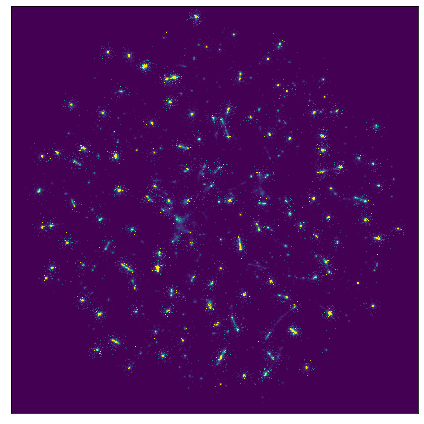

In [6]:
hist2d, edgesX, edgesY = draw_2D_hist(df_Alu)

In [7]:
def hist_to_spots(hist2d, density=True, cutoff = 5, bins=[600, 600], pixel_lower = 1, pixel_upper = 10, show_big_clusters_id=True):
    hist2d = hist2d.copy()
    cutoff = int(cutoff)
    
    # cutoff, how low the number/density will be discard
    if density == True:
        hist2d = hist2d/(hist2d.max()/255.0)
    else:
        hist2d[hist2d>=255] = 255
    hist2d = hist2d.astype('uint8')
    hist2d_raw = hist2d.copy()
    
    thresh = cv2.threshold(hist2d, cutoff, 255, cv2.THRESH_BINARY)[1]
   
    thresh_small = hist2d_raw.copy()
    thresh_small[thresh_small>cutoff] = 0
    thresh_small[thresh_small>0] = 255
    
    contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE) # 
    contours_filtered_small = []
    contours_filtered_big = []
    dropped = []
    
    N = 0
    show_contours_small =np.zeros(bins).astype('uint8')
    show_contours_big =  np.zeros(bins).astype('uint8')
    dict_cnt_big = defaultdict(list)
    dict_cnt_small = defaultdict(list)
    
    mask =np.zeros(bins).astype('uint8')
    stistics = {"big_pixels":0, "big_cnt": 0, "small_pixels":0, "small_cnt":0, "ignored_pixels":0, "ignored_cnt":0}
    for cnt in contours:
        if pixel_lower <cv2.contourArea(cnt)< pixel_upper:
            contours_filtered_small.append(cnt)
            cimg = np.zeros(bins).astype('uint8')
            cv2.drawContours(cimg, [cnt], -1, 255, -1)
            cimg_rot90 = np.rot90(cimg, k = 1)
            pts = np.where(cimg_rot90 == 255)
            stistics["small_cnt"] += 1
            for i,j in zip(*pts):
                # c = hist2d_raw[i, j]
                stistics["small_pixels"] += 1
                dict_cnt_small[int(stistics["small_cnt"])].append((bins[0]-i, j))
        elif cv2.contourArea(cnt) >= pixel_upper:
            contours_filtered_big.append(cnt)
            cimg = np.zeros(bins).astype('uint8')
            cv2.drawContours(cimg, [cnt], -1, 255, -1)
            cimg_rot90 = np.rot90(cimg)
            pts = np.where(cimg_rot90 == 255)
            stistics["big_cnt"] += 1
            for i,j in zip(*pts):
                # c = hist2d_raw[i, j]
                stistics["big_pixels"] += 1
                dict_cnt_big[stistics["big_cnt"]].append((bins[0]-i, j))
        else:
            dropped.append(cnt)
            for item in cnt:
                stistics["ignored_cnt"] += 1
                for x,y in item:
                    c = hist2d_raw[x, y]
                    stistics["ignored_pixels"] += c
                        
    print("Pixels ignored: {} pixels in {} cntour".format(stistics["ignored_pixels"], stistics["ignored_cnt"]))
    print("Big contours: {} pixels in {} cntour".format(stistics["big_pixels"], stistics["big_cnt"]))
    print("Small contour: {} piexels in {} cntour".format(stistics["small_pixels"], stistics["small_cnt"]))
    image = cv2.bitwise_and(thresh, thresh, mask=mask)

    cv2.drawContours(show_contours_small, contours_filtered_small, -1, 255, -1)
    cv2.drawContours(show_contours_big, contours_filtered_big, -1, 255, -1)
    cv2.drawContours(thresh_small, dropped, -1, 255, -1)

    fig, axes = plt.subplots(2,2, sharex=True, sharey=True,figsize=(12,12))
    axes[0][0].imshow(thresh_small)
    axes[0][1].imshow(show_contours_small)
    axes[1][0].imshow(show_contours_big)
    axes[1][1].imshow(thresh)
    axes[0][0].set_title("Ignored pixels")
    axes[0][1].set_title("Small clusters")
    axes[1][0].set_title("Big clusters")
    axes[1][1].set_title("Thresh")
    axes[0][0].set_xticks([]) # 
    axes[0][0].set_yticks([]) #
    
    if show_big_clusters_id == True:
        for id, xy in dict_cnt_big.items():
            Xs = []
            Ys = []
            for x, y in xy:
                Xs.append(x)
                Ys.append(y)
            c_X = np.mean(Xs)
            c_Y = np.mean(Ys)
            
            diameter_X = np.max(Xs) - np.min(Xs)
            diameter_Y = np.max(Ys) - np.min(Ys)
            
            if diameter_X * diameter_Y >= 250:
                color = "red"
            else:
                color = "white"
            axes[1][0].annotate(str(id), xy=(c_X, c_Y), c=color, ha="center", va="center") # 
    '''
    for id, xy in dict_cnt_small.items():
        Xs = []
        Ys = []
        for x, y in xy:
            Xs.append(x)
            Ys.append(y)
        c_X = np.mean(Xs)
        c_Y = np.mean(Ys)
        axes[0][1].annotate(str(id), xy=(c_X, c_Y), c="white") # , ha="center", va="center"
    '''
    plt.tight_layout() 
    return dict_cnt_small, dict_cnt_big


Pixels ignored: 1772 pixels in 5496 cntour
Big contours: 11671 pixels in 147 cntour
Small contour: 2705 piexels in 382 cntour


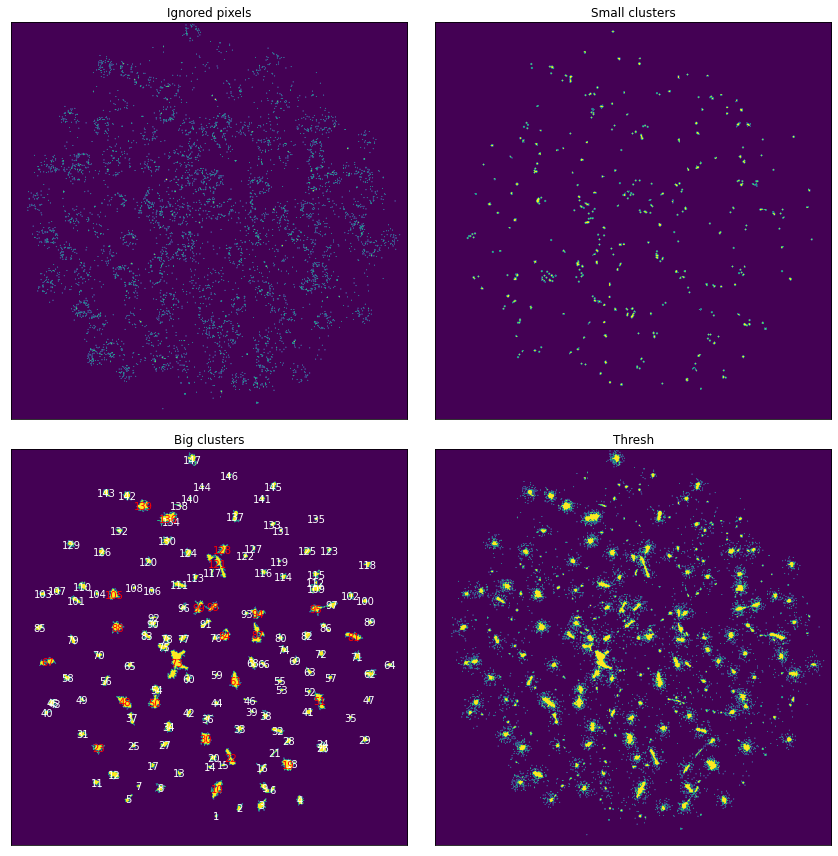

In [8]:
small_clusters, big_clusters =  hist_to_spots(hist2d, density=True, cutoff=0.001*255, show_big_clusters_id=True)

In [9]:
def retrive_clusters(df, edgesX, edgesY, dict_clusters, bins=[600,600], cluster_ids=None, spot_name="spot"):
    df = df.copy()
    indexes = []
    spots  = []
    N = 0
    M = 0
    S = 0
    for spot_id, xy in dict_clusters.items():
        if cluster_ids is None or spot_id in cluster_ids:
            N += 1
            for x, y in xy:
                left = edgesX[x]
                right = edgesX[x+1]
                bottom = edgesY[bins[1]-y-1]
                top = edgesY[bins[1]-y]
                slice = df.loc[(df["X"]>left)& (df["X"]<=right) & (df["Y"]>bottom) & (df["Y"]<=top)]
                indexes.extend(slice.index.tolist())
                spots.extend([spot_id] * slice.shape[0])
                M += 1
                S += slice.shape[0]
                sys.stdout.write("Number of spots: {}, Total pixels:{}, Total sites: {}\r".format(N, M, S))
    df.loc[indexes, "Spot_name"] = spot_name
    df.loc[indexes, "Spot_id"] = spots
    return df

In [10]:
df_Alu_spots = retrive_clusters(df_Alu, edgesX, edgesY, big_clusters, cluster_ids=[48, 60, 73, 87, 121, 147], spot_name="Big")

In [11]:
df_Alu_big = df_Alu_spots[df_Alu_spots["Spot_name"]=="Big"]
df_Alu_big["Spot_id"] = df_Alu_big["Spot_id"].astype(int)
print(df_Alu_big.shape)

(779725, 13)


In [12]:
df_Alu_big.to_csv("REDIportal_hg38.F10.ALU.retrived.UMAP.big_clusters.bigs.csv")

In [13]:
extract_fasta_and_draw_motifs("bigs", df_Alu_big, cluster_col="Spot_id", motif_column="motif_F10", draw_logos=True)

===============  bigs  ===============
Cluster #73: 200245
Cluster #48: 167904
Cluster #147: 137061
Cluster #87: 84471
Cluster #121: 143463
Cluster #60: 46581


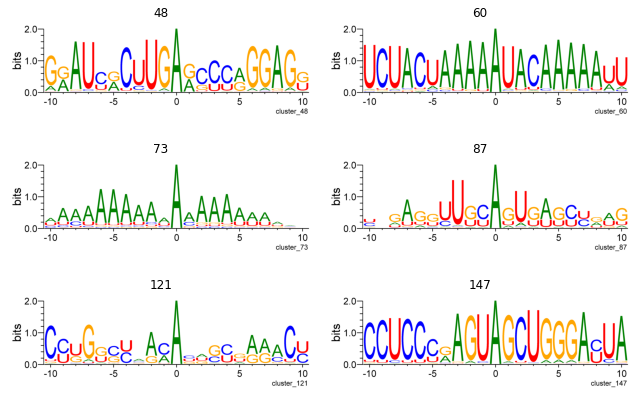

In [23]:
show_logos_cols("./bigs/logos_bits_png/", cols=2, figsize=(9,6))

## 2. Non-Alu repeats

In [15]:
df_Rep = pd.read_csv("./REDIportal_hg38.F10.REP.retrived.UMAP.csv", index_col=0, header=0)
print(df_Rep.shape)

(999240, 11)


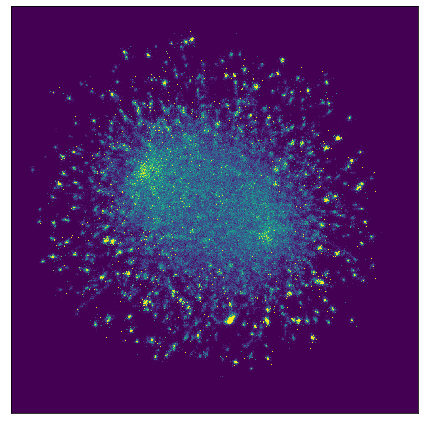

In [16]:
hist2d_rep, edgesX_rep, edgesY_rep = draw_2D_hist(df_Rep, xlim=[-8,8], ylim=[-8,8])

Pixels ignored: 20578 pixels in 12744 cntour
Big contours: 9589 pixels in 2 cntour
Small contour: 10903 piexels in 231 cntour


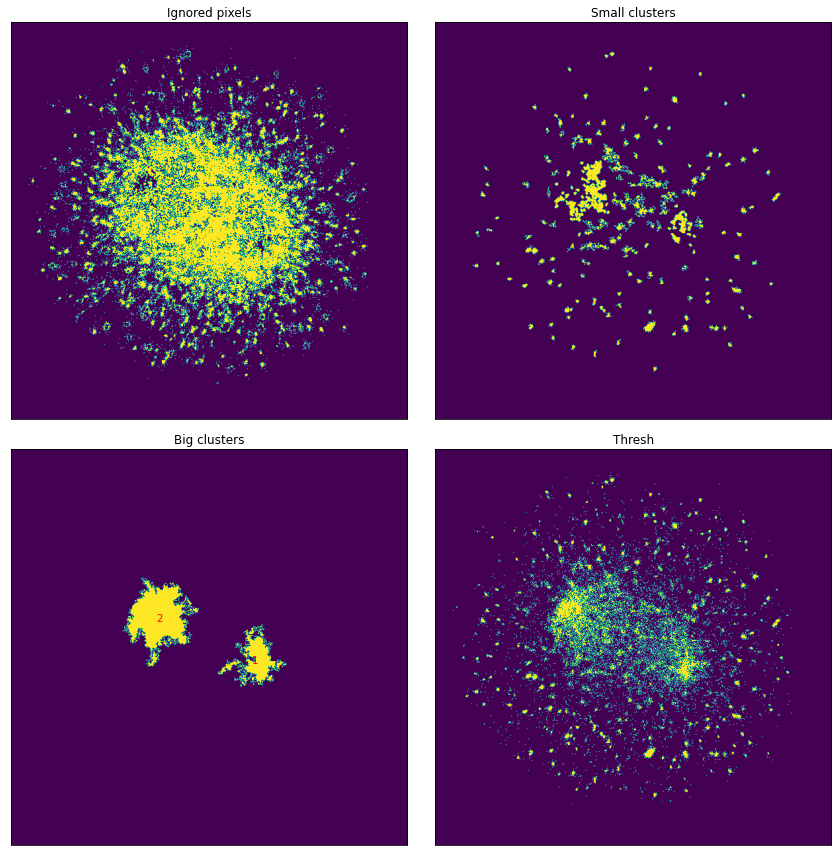

In [17]:
small_clusters_rep, big_clusters_rep = hist_to_spots(hist2d_rep, density=True, cutoff=0.01*255, show_big_clusters_id=True, pixel_lower = 10, pixel_upper =1000)

In [18]:
df_Rep_spots = retrive_clusters(df_Rep, edgesX_rep, edgesY_rep, big_clusters_rep, spot_name="Big")

In [19]:
df_Rep_big = df_Rep_spots[df_Rep_spots["Spot_name"]=="Big"]
df_Rep_big["Spot_id"] = df_Rep_big["Spot_id"].astype(int)
print(df_Rep_big.shape)

(149154, 13)


In [20]:
extract_fasta_and_draw_motifs("bigs_rep", df_Rep_big, cluster_col="Spot_id", motif_column="motif_F10", draw_logos=True)

===============  bigs_rep  ===============
Cluster #1: 43309
Cluster #2: 105845


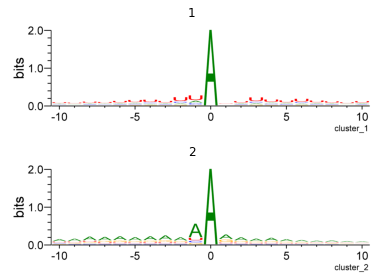

In [21]:
show_logos_cols("./bigs_rep/logos_bits_png/", cols=1, figsize=(6,4))